In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ======= sklearn =======
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,     
    f1_score              
)
# ======= Image Feature Library =======
from skimage.feature import local_binary_pattern

In [2]:
# ======= Parameter Settings =======
LBP_METHOD = 'uniform'
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_NEIGHBORS = 18
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

In [3]:
# ======= 1. Load data =======
def load_and_split_dataset(dataset_path, test_size=0.2, sample_ratio=1.0):
    images, labels = [], []
    class_names = sorted(os.listdir(dataset_path))

    for label in class_names:
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir):
            continue
        filenames = sorted(os.listdir(class_dir))
        if sample_ratio < 1.0:
            filenames = filenames[:int(len(filenames) * sample_ratio)]

        for file in filenames:
            img_path = os.path.join(class_dir, file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=RANDOM_STATE, stratify=labels
    )
    return (X_train, y_train), (X_test, y_test), class_names

In [4]:
# ======= 2. LBP feature extraction =======
def extract_lbp_features(images, radius=LBP_RADIUS, points=LBP_POINTS, method=LBP_METHOD):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, points, radius, method)
        hist, _ = np.histogram(
            lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2)
        )
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        features.append(hist)
    return np.array(features)

In [5]:
# ======= 3. Model Evaluation =======
def evaluate_model(y_true, y_pred, class_names, k, radius):
    print(f"=== Evaluation Results (k={k}, radius={radius}) ===")
    print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))
    print("Precision (Macro): {:.4f}".format(precision_score(y_true, y_pred, average='macro')))
    print("F1-Score (Macro): {:.4f}".format(f1_score(y_true, y_pred, average='macro')))
    print("Weighted Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("Macro Recall:", recall_score(y_true, y_pred, average='macro'))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
                yticklabels=class_names, cmap='Blues')
    plt.title(f"Confusion Matrix (k={k}, radius={radius})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


In [6]:
# ======= 4. Contrasting displays of success/failure =======
def show_comparison_examples(images, y_true, y_pred, num=5):
    correct = [i for i in range(len(y_true)) if y_true[i] == y_pred[i]]
    wrong = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
    
    total = min(num, len(correct), len(wrong))
    plt.figure(figsize=(15, 4))
    for i in range(total):
     
        idx_c = correct[i]
        plt.subplot(2, total, i + 1)
        plt.imshow(cv2.cvtColor(images[idx_c], cv2.COLOR_BGR2RGB))
        plt.title(f"True: {y_true[idx_c]}\nPred: {y_pred[idx_c]}", fontsize=10)
        plt.axis('off')

        idx_w = wrong[i]
        plt.subplot(2, total, total + i + 1)
        plt.imshow(cv2.cvtColor(images[idx_w], cv2.COLOR_BGR2RGB))
        plt.title(f"True: {y_true[idx_w]}\nPred: {y_pred[idx_w]}", fontsize=10)
        plt.axis('off')

    plt.suptitle("Top Row: Correct • Bottom Row: Incorrect Predictions", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

In [7]:
# ======= 5. Ablation: different k =======
def ablation_knn_k_comparison(X_train, y_train, X_test, y_test, class_names, k_list=[12, 14, 16, 18, 20]):
    print("\n=== Ablation Study: Different k in kNN ===")
    best_k = k_list[0]
    best_acc = 0
    for k in k_list:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        macro = recall_score(y_test, y_pred, average='macro')
        weighted = recall_score(y_test, y_pred, average='weighted')
        print(f"k = {k}: Accuracy = {acc:.4f}, Macro Recall = {macro:.4f}, Weighted Recall = {weighted:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_k = k
    return best_k, best_acc


In [8]:
# ======= 6. Ablation: different LBP radii =======
def ablation_lbp_radius_comparison(images, labels, radius_list=[1, 3, 5]):
    print("\n=== Ablation Study: Different LBP Radius ===")
    best_radius = radius_list[0]
    best_acc = 0
    best_features = None
    best_labels = None

    for radius in radius_list:
        points = radius * 8
        features = extract_lbp_features(images, radius=radius, points=points)
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=TEST_SIZE, stratify=labels)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf = KNeighborsClassifier(n_neighbors=16)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        macro = recall_score(y_test, y_pred, average='macro')
        weighted = recall_score(y_test, y_pred, average='weighted')
        print(f"Radius = {radius}: Accuracy = {acc:.4f}, Macro Recall = {macro:.4f}, Weighted Recall = {weighted:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_radius = radius
            best_features = (features, labels)
    return best_radius, best_features

Training: 9600, Test: 2400

=== Ablation Study: Different LBP Radius ===
Radius = 1: Accuracy = 0.5400, Macro Recall = 0.5400, Weighted Recall = 0.5400
Radius = 3: Accuracy = 0.5421, Macro Recall = 0.5421, Weighted Recall = 0.5421
Radius = 5: Accuracy = 0.5225, Macro Recall = 0.5225, Weighted Recall = 0.5225

=== Ablation Study: Different k in kNN ===
k = 12: Accuracy = 0.5354, Macro Recall = 0.5354, Weighted Recall = 0.5354
k = 14: Accuracy = 0.5458, Macro Recall = 0.5458, Weighted Recall = 0.5458
k = 16: Accuracy = 0.5433, Macro Recall = 0.5433, Weighted Recall = 0.5433
k = 18: Accuracy = 0.5450, Macro Recall = 0.5450, Weighted Recall = 0.5450
k = 20: Accuracy = 0.5363, Macro Recall = 0.5363, Weighted Recall = 0.5363

[INFO] Final Parameters Used: k = 14, LBP radius = 3

=== Final Evaluation Based on Best Parameters ===
=== Evaluation Results (k=14, radius=3) ===
Accuracy: 0.5458
Precision (Macro): 0.5559
F1-Score (Macro): 0.5400
Weighted Recall: 0.5458333333333333
Macro Recall: 0.54

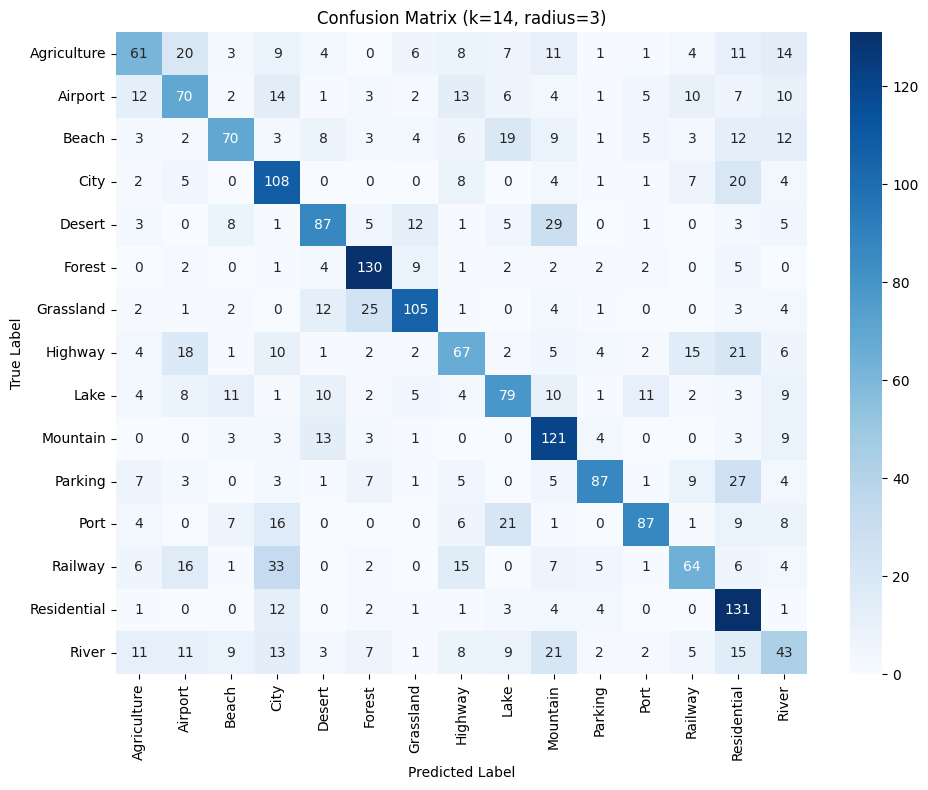


Showing comparison of correct vs incorrect predictions:


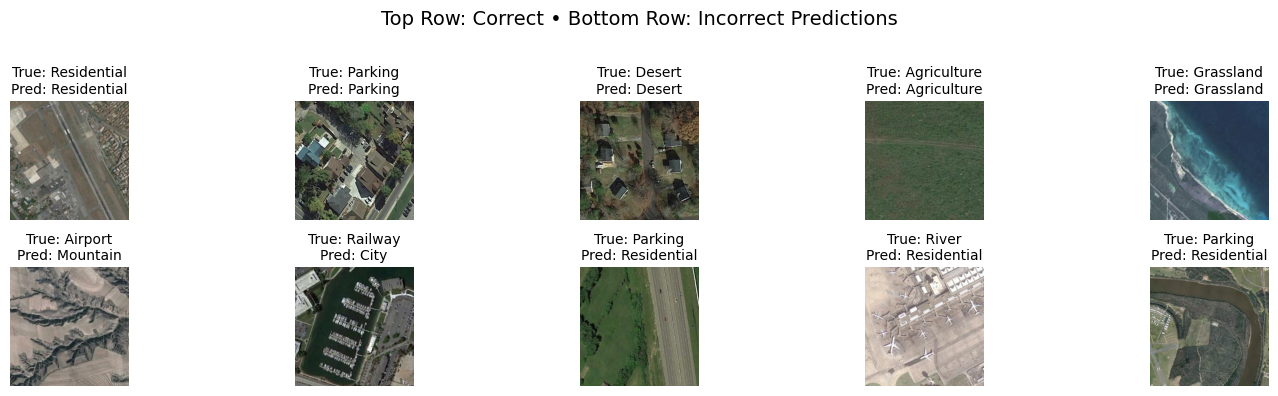

In [9]:
def main():
    dataset_path = "/kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes"

    (train_images, train_labels), (test_images, test_labels), class_names = load_and_split_dataset(
        dataset_path, test_size=TEST_SIZE
    )
    print(f"Training: {len(train_images)}, Test: {len(test_images)}")

    all_images = train_images + test_images
    all_labels = train_labels + test_labels

    # Step 1: Ablation to get best LBP radius
    best_radius, (all_features, all_labels) = ablation_lbp_radius_comparison(all_images, all_labels)
    best_points = best_radius * 8

    # Step 2: Use best LBP radius to split and extract features
    X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=TEST_SIZE, stratify=all_labels)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Step 3: Ablation to get best k
    best_k, _ = ablation_knn_k_comparison(X_train, y_train, X_test, y_test, class_names)

    print(f"\n[INFO] Final Parameters Used: k = {best_k}, LBP radius = {best_radius}")
    print("\n=== Final Evaluation Based on Best Parameters ===")
    clf = KNeighborsClassifier(n_neighbors=best_k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluate_model(y_test, y_pred, class_names, best_k, best_radius)

    # Optional: Visualize correct vs incorrect
    print("\nShowing comparison of correct vs incorrect predictions:")
    show_comparison_examples([all_images[i] for i in range(len(all_labels)) if all_labels[i] in y_test],
                             y_test, y_pred, num=5)
if __name__ == "__main__":
    main()